In [1]:
using EaRyd
using Random
Random.seed!(42)

Random.TaskLocalRNG()

build lattice

In [2]:
nsites = 10
atoms = generate_sites(ChainLattice(), nsites, scale=5.72)
h = rydberg_h(atoms;C = 2π * 858386, Ω=4π)
config = rand(0:1, 10)
init = product_state(config)

ArrayReg{1, ComplexF64, Array...}
    active qubits: 10/10

# construct time evolution
the Hamiltonian is
$$
\sum n_i n_j
$$
![image](assets/myimage.png)
[text](url)

In [3]:
iteration = 1:120
ts = [0.01 for _ in iteration];
hs = [h for _ in iteration];
prob = KrylovEvolution(init, ts, hs)

KrylovEvolution{Float64}:
  reg: YaoArrayRegister.ArrayReg{1, ComplexF64, Matrix{ComplexF64}}
  reg storage: 16.000 KiB

  total duration: 1.2000000000000002 μs

  hamiltonian: 
    Hamiltonian
      Term 1
       ∑(n=1:10) 12.6/2 σ^x

      Term 2
       ∑(n=1:10) 5.39e6/|r_i - r_j|^6 n_i n_j

       ⋮

    Hamiltonian
      Term 1
       ∑(n=1:10) 12.6/2 σ^x

      Term 2
       ∑(n=1:10) 5.39e6/|r_i - r_j|^6 n_i n_j

  hamiltonian storage: 135.875 KiB

  options: 
    progress: false
    progress_step: 1
    progress_name: "emulating"
    normalize_step: 5
    normalize_finally: true

measuring obervable

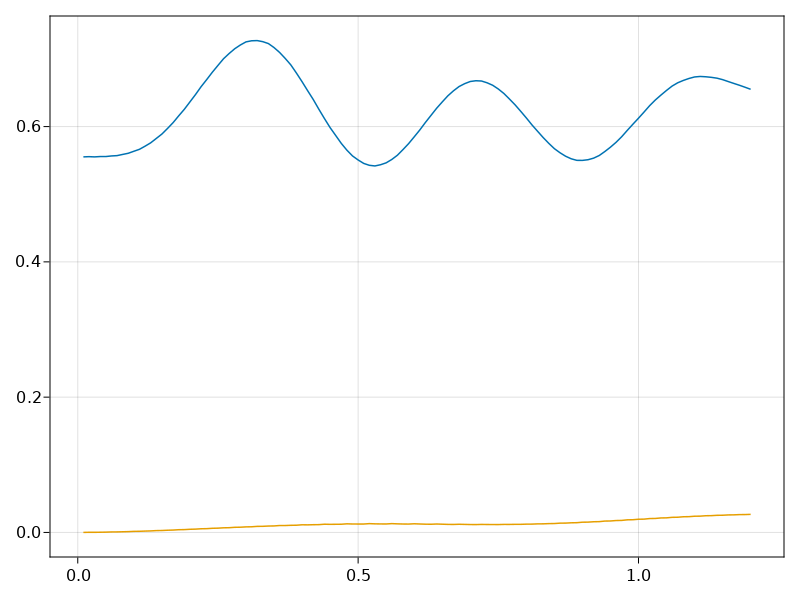

In [4]:
clocks = cumsum(ts)
entropy = zeros(length(iteration))
domain_mat = zeros(nsites-1, length(iteration))
density_mat = zeros(nsites, length(iteration))

for info in prob
    for i in 1:nsites
        density_mat[i, info.step] = expect(put(nsites, i=>Op.n), info.reg)
    end

    for i in 1:nsites-1
        corr = real(expect(put(nsites, (i, i+1)=>kron(Op.n, Op.n)), info.reg))
        obs = density_mat[i, info.step] + density_mat[i+1, info.step] - 2corr
        domain_mat[i, info.step] = obs
    end

    rho = density_matrix(info.reg, (1,2,3,4,5))
    entropy[info.step] = von_neumann_entropy(rho)
end

using CairoMakie
fig = Figure(size=(10, 5));
ax = Axis(fig[1, 1])

for i in 1:nsites
    lines!(clocks, density_mat[i, :])
end
fig

heatmap(clocks, 1:nsites, density_mat')
heatmap(clocks, 1:nsites, domain_mat')
domain_avg = vec(sum(domain_mat, dims=1)/(nsites-1))
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax, clocks, domain_avg)
lines!(ax, clocks, entropy)
fig

TODO: subspace

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*